In [1]:
# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements.  See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership.  The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License.  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied.  See the License for the
# specific language governing permissions and limitations
# under the License. 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Analysis of the Accuracy of the Approximate Davies Generator applied to Adversarial Hamiltonian

Attempting to construct a Davies generator using standard phase estimation results in approximation errors: it is now no longer clear that the steady state of the Davies generator is the thermal state of any Hamiltonian. We know of no method of analytically bounding the distance of the steady state from the desired thermal state.

It is not clear if this is actually a problem in practice. However, it is possible to construct an 'adversarial' Hamiltonian that aims to make the error as large as possible. In this notebook we explore how severe the error can be when we apply the approximate Davies generator based on phase estimation to this adversarial Hamiltonian. 





## Contents

1. Summary of Imported Scripts
2. Adversarial Hamiltonian
3. Approximate Davies Generator
4. Accuracy of the Steady State


## 1. Summary of Imported Scripts

In [2]:
from src.rounding_promises import *
# get_thermal_state(eigs,beta)

from src.poly_construction import *
# apply_to_H(f, eigs)

from src.lindblad_analysis import *
# get_lindblad(calJ, pi, couplers, beta)
# get_steady_state(L)
# make_couplers(nqubits, eigv)

from src.caching import *
# collect_data(*args, fn=,filename=,nthreads=1,prec=3,timing=True)
# print_available_data(filename, fn)

## 2. Adversarial Hamiltonian

The adversarial Hamiltonian's energies are of the form:

$$  \frac{j + \alpha/2}{2^n} $$

where $0 <= j < 2^n$ and $\alpha \in [0,1]$. The eigenvalues are repeated in order to fill up a Hilbert space with `nqubits` many qubits.

The 'adversariality' $\alpha$ tunes the positions of the eigenvalues. If $\alpha = 0$ then the eigenvalues are exactly multiples of $1/2^n$, making phase estimation perfect. When $\alpha = 1$ then the energies are rounded up or down with equal probability. So, the larger $\alpha$ is, the worse the error due to rounding.


In [3]:
def adversarial_hamiltonian(n,nqubits,alpha):
    k = nqubits - n
    eigs = []
    for i in range(2**n):
        for j in range(2**k):
            eigs.append( (i + alpha/2) * 2**(-n)  )
    return eigs, np.eye(2**(n+k))

## 3. Approximate Davies Generator

Here we construct an approximate Davies generator with energy estimation based on phase estimation. The filter function is:

$$f^2(x, \lambda) =  \frac{\sin^2(\pi (2^n\lambda - x)}{\pi^2 (2^n \lambda - x)^2} $$

The `amps` parameter lets us also amplify the success probability of this filter function via median estimation.


In [4]:
def approximate_davies_generator_error(beta,eigs,eigv,n,amps):
    # median amplification parameter: amps
    # take the median of amps many estimates.
    assert 2*(amps // 2)+1 == amps  # must be odd.
    # to turn median amplification off, set amps=1.

    couplers = make_couplers(eigv)
    
    # Bohr frequencies rounded to multiples of 1/2^n
    calJ = {}
    for i in range(2**n):
        for j in range(2**n):
            omega = (i-j)/2**n
            if omega not in calJ: calJ[omega] = []
            calJ[omega].append((i,j))

    # Filter function from phase estimation
    def pi_f(x,eig):
        k = (amps //2)+1

        eig = (2**n * eig) - x
        if eig == 0: return 1
        p = np.sin(np.pi * eig)**2 / ( np.pi**2 * eig**2  )

        if amps == 1: return p
        return 1-binom.cdf(k,amps,p)
    
    pi = lambda x: apply_to_H(lambda eig: pi_f(x,eig),eigs)
    
    L = get_lindblad(calJ, pi, couplers, beta)
    
    steady, error = get_steady_state(L)
    
    if error is not None: return error
    
    target = get_thermal_state(eigs, beta)
    return np.linalg.norm(target-steady,ord='nuc')/2

## 4. Accuracy of the Steady State

In [5]:
def adversarial_approximate_davies_generator_error(n:int,nqubits:int,
                                                   alpha:float,beta:float,amps:int):
    eigs, eigv = adversarial_hamiltonian(n,nqubits,alpha)
    return approximate_davies_generator_error(beta,eigs,eigv,n,amps)

In [29]:
def plot_adversarial_accuracy(n,nqubits,alphas,beta,ampss):
    apx_data = collect_data(n,nqubits,alphas,beta,ampss,
                        fn=adversarial_approximate_davies_generator_error,
                        filename="data.json",nthreads=3)
    
    series = {}
    for key,error in apx_data.items():
        alpha, beta, amps = key[2], key[3], key[4]
        #label = "$\\beta = {},$ amps = {}".format(beta,amps)
        label = "$M$ = {}".format(amps)
        if label not in series: series[label] = []
        series[label].append((alpha,error))
        
        
    linestyles = ["-","--",":","-."]
    assert len(linestyles) >= len(series.items())
        
    for ls,(key,data) in zip(linestyles,series.items()):
        plt.plot(*zip(*data), label=key, c="k",ls=ls)
        plt.scatter(*zip(*data),c="k",s=15)

        
    plt.legend()
    plt.grid()
    plt.title("Accuracy of the Steady State\n"+
              "of the Approximate Davies Generator\n"+
             "with an Adversarial Hamiltonian\n"+
             "on {} qubits with accuracy 2^-{}\n".format(nqubits,n)+
             "$\\beta$ = {}".format(beta))
    plt.ylabel("Error in Trace Distance")
    plt.xlabel("Adversariality Parameter $\\alpha$")
        

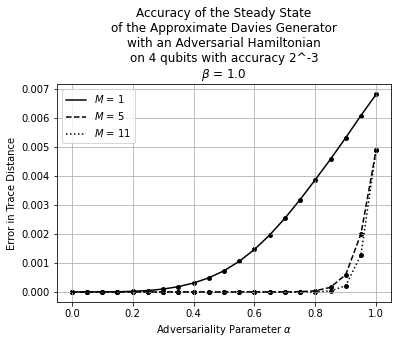

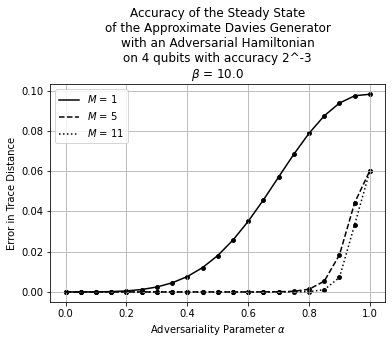

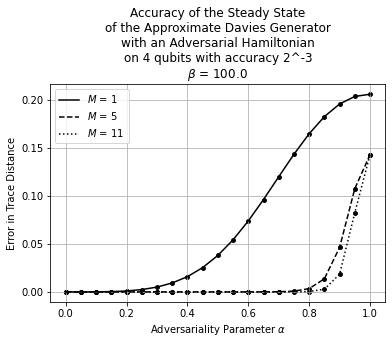

In [35]:
for beta in [1,10,100]:
    ampss  = [1,5,11]
    plot_adversarial_accuracy(3,4,np.arange(0,1.05,0.05),beta,ampss)
    plt.savefig("export/adversarial_beta"+str(beta)+".pdf")
    plt.show()